# Stack Exchange Personalized Prediction Data
Stack Exchange Personalized Prediction Data is the data which Stack Exchange (which contains Stack Overflow) has accumulated from the user behavior to make prediction for personal recommendation such as job listings. See [here](https://meta.stackexchange.com/users/prediction-data) for official explanation. 

Stack Exchange allows users to download their personalized data. The data contains information which describes our behavior using things like tags (c++, javascript, python, etc. for my case) with some coefficients. Although there is no documentation about what each value means, it is interesting to see what it looks like.

In this notebook, I'm going to explore my data.

#### References:
- [Personalized Prediction Data - Meta Stack Exchange](https://meta.stackexchange.com/users/prediction-data)
- [Documentation on the personalized prediction data](https://meta.stackexchange.com/questions/250062/documentation-on-the-personalized-prediction-data)
- [Targeted Jobs for Stack Overflow - Stack Overflow Blog](https://stackoverflow.blog/2015/01/27/targeted-jobs-for-stack-overflow/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

%matplotlib inline
sns.set()

In [2]:
with open("Stack Exchange personalized prediction data 2018-06-04.json") as f:
    data_json = json.load(f)

## Data/TagViews
In the json data, Data/TagViews contains key-value pair of {"tag name": "value"}. Let's see what it looks like.

In [3]:
tag_views_json = data_json['Data']['TagViews']

In [4]:
tag_views_df = pd.DataFrame(
                    data=list(tag_views_json.values()),
                    index=list(tag_views_json.keys()),
                    columns=['TagViews']
               )

In [5]:
tag_views_df.head()

,TagViews
c#,130
algorithm,7
java,16
oop,6
object,8


In [6]:
tag_views_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141 entries, c# to jquery-ui
Data columns (total 1 columns):
TagViews    141 non-null int64
dtypes: int64(1)
memory usage: 2.2+ KB


In [7]:
tag_views_df.describe()

,TagViews
count,141.000000
mean,13.333333
std,43.669157
min,1.000000
25%,1.000000
50%,2.000000
75%,8.000000
max,440.000000


In [8]:
sorted_tag_views_df = tag_views_df.sort_values(by='TagViews', ascending=False)

In [9]:
sorted_tag_views_df.head()

,TagViews
c++,440
javascript,183
c#,130
python,123
c++11,84


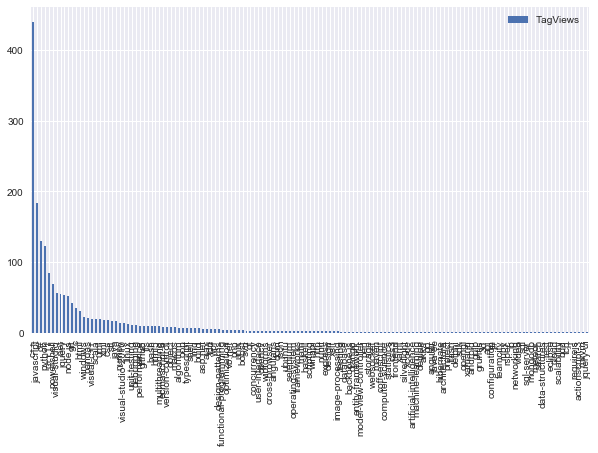

In [10]:
sorted_tag_views_df.plot.bar(figsize=(10, 6))

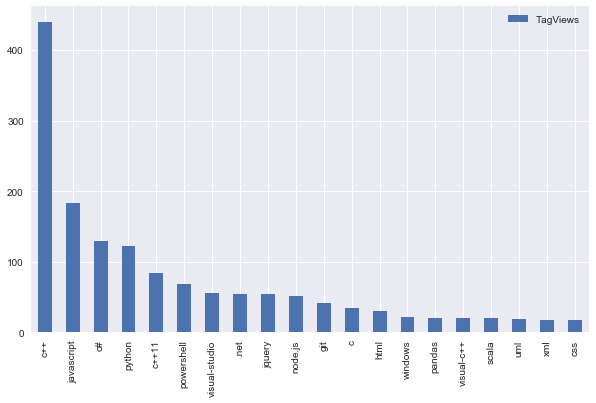

In [11]:
sorted_tag_views_df[:20].plot.bar(figsize=(10, 6))

The above bar chart shows the sorted list of tags in Data/TagViews in the json data. The order and value of tags seem fitting with my feelings of the areas I'm working on.

## Data/InterestingTags/stackoverflow.com
In the json data, Data/InterestingTags/stackoverflow.com contains key-value pair of {"tag name": "value"}. It seems similar to the previous Data/TagViews, but the difference is that Data/TagViews has integer values but in this case there are floating point values less than 1. Let's see what it looks like.

In [12]:
interesting_tags_json = data_json['Data']['InterestingTags']['stackoverflow.com']

In [13]:
interesting_tags_df = pd.DataFrame(
                    data=list(interesting_tags_json.values()),
                    index=list(interesting_tags_json.keys()),
                    columns=['InterestingTags']
               )

In [14]:
interesting_tags_df.head()

,InterestingTags
c++,0.376449
javascript,0.062643
c,0.043115
html,0.037179
python,0.036670


In [15]:
interesting_tags_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, c++ to android-service
Data columns (total 1 columns):
InterestingTags    999 non-null float64
dtypes: float64(1)
memory usage: 15.6+ KB


In [16]:
interesting_tags_df.describe()

,InterestingTags
count,999.000000
mean,0.001359
std,0.012464
min,0.000117
25%,0.000160
50%,0.000254
75%,0.000518
max,0.376449


In [17]:
interesting_tags_df.sum()

InterestingTags    1.357482
dtype: float64

So, following things are found:
 - There are more tags compared to Data/TagViews.
 - The sum of value is NOT 1, so the values do not seem to be some kind of ratio.
 
Again, let's visualize the values.

In [18]:
sorted_interesting_tags_df = interesting_tags_df.sort_values(
    by='InterestingTags', ascending=False)

In [19]:
sorted_interesting_tags_df.head()

,InterestingTags
c++,0.376449
javascript,0.062643
c,0.043115
html,0.037179
python,0.036670


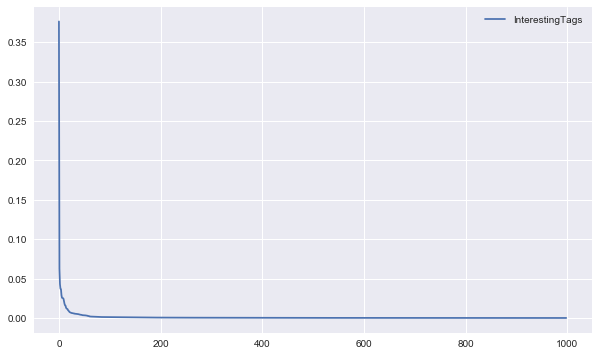

In [20]:
sorted_interesting_tags_df.reset_index().plot.line(figsize=(10, 6))

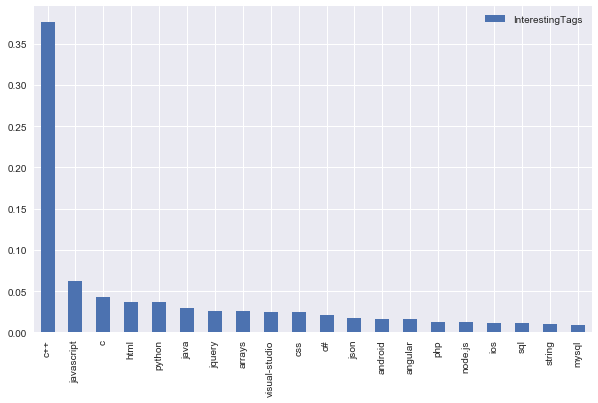

In [21]:
sorted_interesting_tags_df[:20].plot.bar(figsize=(10, 6))

In this case, the result is against my feelings because I'm not working on "java", "android", "php", and "ios".

It seems Data/TagViews correctly describes my behavior on Stack Overflow, but Data/InterestingTags/stackoverflow.com does not.

From here, I'm going to take correlation of Data/TagViews and Data/InterestingTags/stackoverflow.com to see the similarity.

The first thing I noticed is that the tags in Data/InterestingTags/stackoverflow.com is not the complete superset of tags in Data/TagViews as shown below.

In [22]:
tag_views_df.join(interesting_tags_df).info()

<class 'pandas.core.frame.DataFrame'>
Index: 141 entries, c# to jquery-ui
Data columns (total 2 columns):
TagViews           141 non-null int64
InterestingTags    130 non-null float64
dtypes: float64(1), int64(1)
memory usage: 8.3+ KB


So, take the intersection of these two tag sets, and let's see the correlation.

In [23]:
tag_views_df.join(interesting_tags_df, how='inner').corr()

,TagViews,InterestingTags
TagViews,1.000000,0.904461
InterestingTags,0.904461,1.000000


From this result, TagViews and InterestingTags is highly correlated. But, this is largely due to the highest-value tag, c++.

In [24]:
tag_views_df.join(interesting_tags_df, how='inner').drop('c++').corr()

,TagViews,InterestingTags
TagViews,1.00000,0.69676
InterestingTags,0.69676,1.00000


Now, I can see the level of correlation. My guess are as follows:
 - TagViews describes my behavior well (from some sort of algorithm), but
 - InterestingTags does similar things as TagViews but the different part of the algorithm of calculating InterestingTags compared to TagViews puts some noise on it.

## Data/Features

Data/Features has similar data of tag-value pairs, so let's explore.

In [25]:
features_df = pd.DataFrame.from_dict(data_json['Data']['Features'])

In [26]:
features_df.head()

,Feature,FeatureType,Group,Order,Value
0,post,TagVisits.TagPercent.OneYear,-1,-1,0.000626
1,pandas,TagVisits.TagPercent.OneYear,-1,-1,0.015019
2,r,TagVisits.TagPercent.OneYear,-1,-1,0.000626
3,text,TagVisits.TagPercent.OneYear,-1,-1,0.001252
4,math,TagVisits.TagPercent.OneYear,-1,-1,0.001252


In [27]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 5 columns):
Feature        322 non-null object
FeatureType    322 non-null object
Group          322 non-null int64
Order          322 non-null int64
Value          322 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 12.7+ KB


In [28]:
features_df.describe()

,Group,Order,Value
count,322.000000,322.000000,322.000000
mean,-0.962733,-0.847826,5.012533
std,0.270875,0.849305,89.050508
min,-1.000000,-1.000000,0.000626
25%,-1.000000,-1.000000,0.000626
50%,-1.000000,-1.000000,0.001877
75%,-1.000000,-1.000000,0.005632
max,1.000000,7.000000,1598.000000


In [29]:
features_df.nunique()

Feature        312
FeatureType      5
Group            2
Order            9
Value           42
dtype: int64

It seems Value is interesting against Feature. But, Feature has dupulicate items because the number of the unique items, 312, is is less than the total count, 322.

In [30]:
features_df['Feature'].value_counts().head(10)

c++                 3
c#                  3
powershell          3
html                2
css                 2
visualstudio        2
javascript          2
image-processing    1
base64              1
numpy               1
Name: Feature, dtype: int64

So, Feature such as powershell is duplicated.

In [31]:
features_df['FeatureType'].value_counts()

TagVisits.TagPercent.OneYear    307
Story.Tag.Liked                   8
Story.Tag.Job                     4
Story.Title.Word.Job              2
SingleFeature                     1
Name: FeatureType, dtype: int64

In [32]:
features_df[features_df['FeatureType'] == 'TagVisits.TagPercent.OneYear']['Feature'].count()

307

In [33]:
features_df[features_df['FeatureType'] == 'TagVisits.TagPercent.OneYear']['Feature'].nunique()

307

If we use Feature whose FeatureType is 'TagVisits.TagPercent.OneYear', such Feature will be unique.

Given that FeatureType is 'TagVisits.TagPercent.OneYear', let's explore Value against Feature.

In [34]:
target_feature_df = (
     features_df[features_df['FeatureType'] == 'TagVisits.TagPercent.OneYear']
     .set_index('Feature')
     [['Value']]
)

In [35]:
sorted_feature_df = target_feature_df.sort_values(by='Value', ascending=False)

In [36]:
sorted_feature_df.head()

,Value
Feature,
c++,0.291615
c#,0.161452
javascript,0.126408
python,0.081977
.net,0.057572


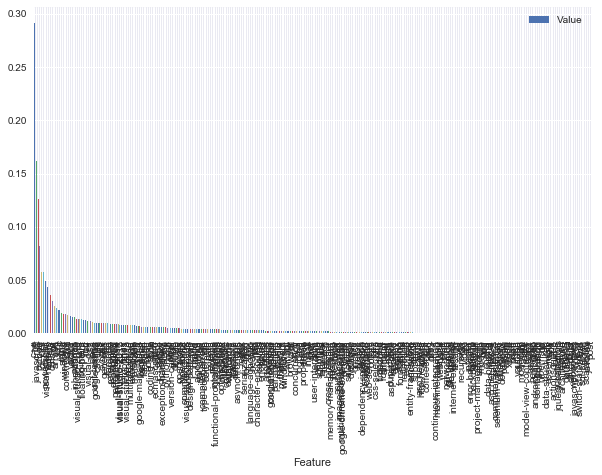

In [37]:
sorted_feature_df.plot.bar(y='Value', figsize=(10, 6))

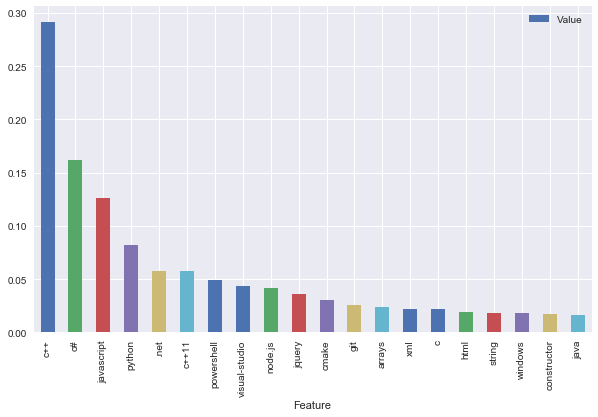

In [38]:
sorted_feature_df.head(20).plot.bar(y='Value', figsize=(10, 6))

This Feature has similar tendency to previous two items, Data/TagViews and Data/InterestingTags/stackoverflow.com.

I feel like this data is somewhere between Data/TagViews and Data/InterestingTags/stackoverflow.com.

# Closing
In this notebook, I looked at three kinds of data which shares the structure of tag-value pairs.
 - Data/TagViews
 - Data/InterestingTags/stackoverflow.com
 - Data/Features
 
Among these three, I feel that Data/TagViews best describes me. Other two do well but I recognize that they have things which I'm not working on.